Deepfake Detection using InceptionResNetV2

Importing Libraries

In [ ]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
input_shape = (128, 128, 3)
data_dir = '/content/drive/MyDrive/RS Deepfake/Deepfake_Data'

real_data = [f for f in os.listdir(data_dir+'/Real') if f.endswith('.jpg')]
fake_data = [f for f in os.listdir(data_dir+'/Fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/Real/'+img, target_size=(128, 128))).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/Fake/'+img, target_size=(128, 128))).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y
#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)
#Reshape
X = X.reshape(-1, 128, 128, 3)

Splitting Data

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

Buildling the Model

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 2, 2, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_11 (Dense)            (None, 2)                 3074      
                                                                 
Total params: 54339810 (207.29 MB)
Trainable params: 54279266 (207.06 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [ ]:
EPOCHS = 5
BATCH_SIZE = 2
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/5
32/32 [==============================] - 117s 2s/step - loss: 0.7883 - accuracy: 0.6508 - val_loss: 0.2174 - val_accuracy: 1.0000
Epoch 2/5
32/32 [==============================] - 44s 1s/step - loss: 0.4096 - accuracy: 0.8413 - val_loss: 2.1394 - val_accuracy: 0.5000
Epoch 3/5
32/32 [==============================] - 46s 1s/step - loss: 0.3688 - accuracy: 0.8571 - val_loss: 1.0497 - val_accuracy: 0.6875
Epoch 4/5
32/32 [==============================] - 45s 1s/step - loss: 0.4451 - accuracy: 0.7937 - val_loss: 8.3501 - val_accuracy: 0.6250
Epoch 5/5
32/32 [==============================] - 44s 1s/step - loss: 0.3666 - accuracy: 0.8413 - val_loss: 0.6813 - val_accuracy: 0.7500


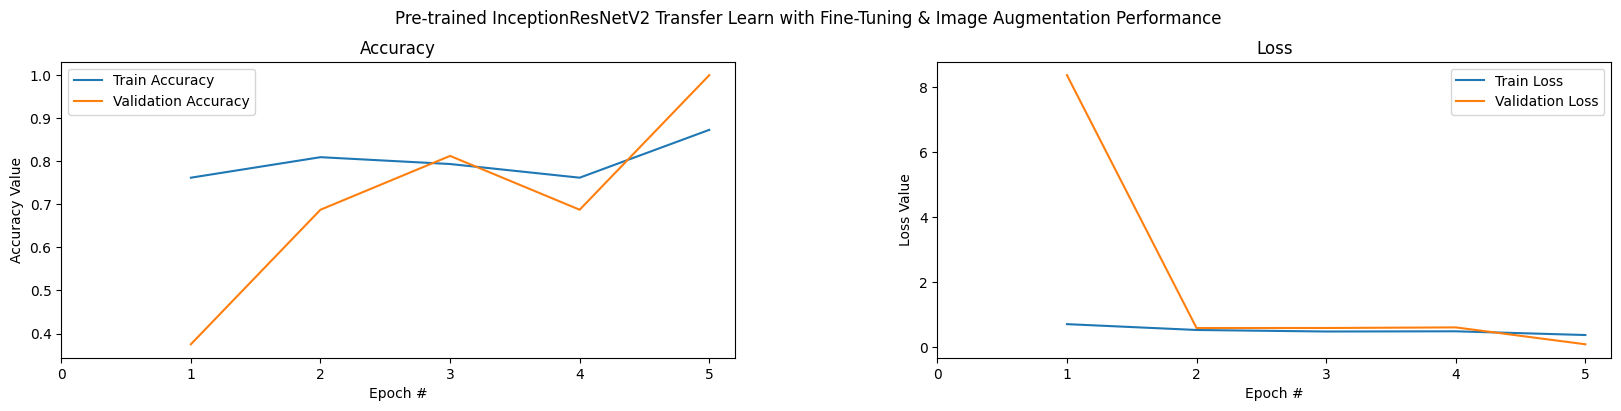

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)

3/3 [==============================] - 5s 1s/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0
 0 0 0 0 0]


Confusion Matrix

True positive =  31
False positive =  19
False negative =  0
True negative =  29




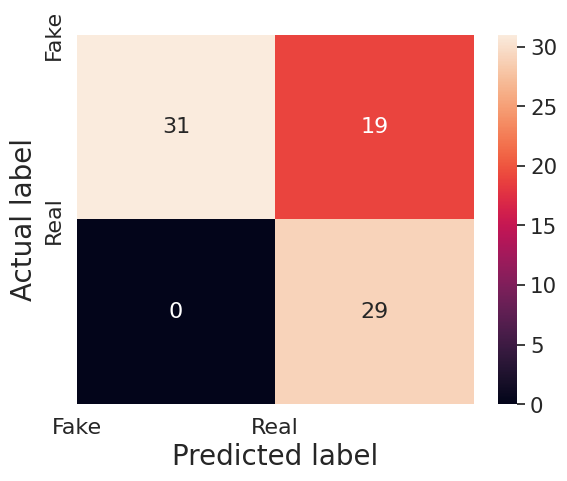

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

print_confusion_matrix(Y_val_org, y_pred)